In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os,sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
# from wordcloud import WordCloud

In [ ]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [ ]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            combined.append(slack_data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [ ]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [ ]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [77]:
# which user has the highest number of reply counts?
import os
import json
  
data_folder = "../anonymized/all-week1/"

# Count the reply counts for each user
reply_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            sender_id = message.get("user")
            if "reply_count" in message.keys():
                reply_count = message.get("reply_count")

                if sender_id in reply_counts:
                    reply_counts[sender_id] += reply_count
                else:
                    reply_counts[sender_id] = reply_count

# Find the user with the highest reply count
user_with_highest_count = max(reply_counts, key=reply_counts.get)
highest_reply_count = reply_counts[user_with_highest_count]

print("User with the highest reply count:", user_with_highest_count)
print("Highest reply count:", highest_reply_count)


User with the highest reply count: U03V6HMRPGQ
Highest reply count: 80


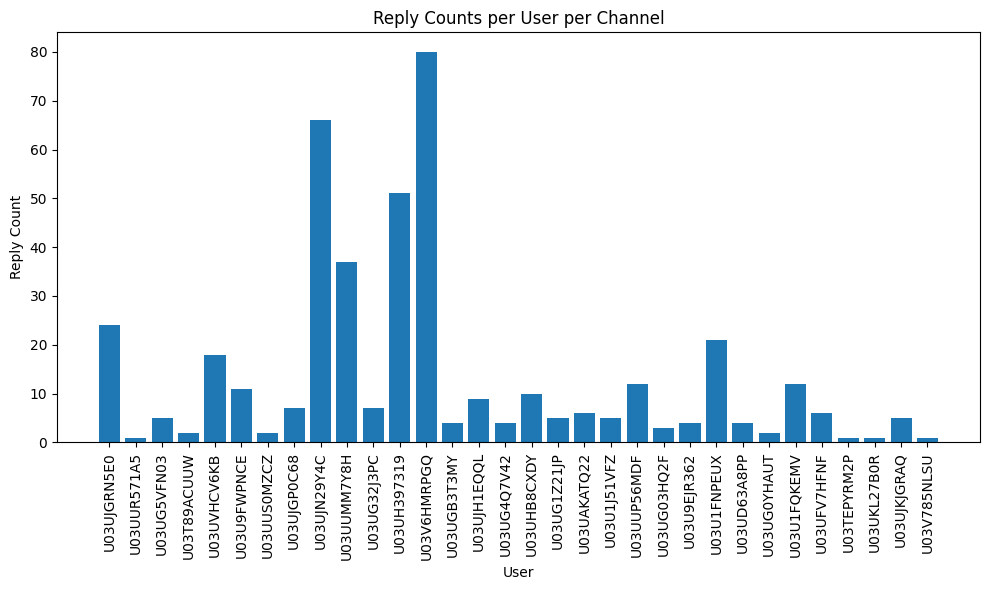

In [30]:
# Visualize reply counts per user per channel
import os
import json
import matplotlib.pyplot as plt

data_folder = "../anonymized/all-week1/"

# Count the reply counts for each user per channel
reply_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            sender_id = message.get("user")
            channel_id = message.get("channel")
            if "reply_count" in message.keys():
                reply_count = message.get("reply_count")

                if channel_id in reply_counts:
                    if sender_id in reply_counts[channel_id]:
                        reply_counts[channel_id][sender_id] += reply_count
                    else:
                        reply_counts[channel_id][sender_id] = reply_count
                else:
                    reply_counts[channel_id] = {sender_id: reply_count}

# Prepare data for visualization
users = []
channels = []
counts = []

for channel, user_counts in reply_counts.items():
    for user, count in user_counts.items():
        users.append(user)
        channels.append(channel)
        counts.append(count)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(counts)), counts)
plt.xlabel("User")
plt.ylabel("Reply Count")
plt.xticks(range(len(counts)), users, rotation=90)
plt.title("Reply Counts per User per Channel")
plt.tight_layout()
plt.show()

In [34]:
# what is the time range of the day that most messages are sent?
import os
import json
from datetime import datetime

data_folder = "../anonymized/all-week1/"

# Count the number of messages for each time range
time_ranges = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            timestamp = message.get("timestamp")
            if timestamp:
                # Convert the timestamp to datetime object
                dt = datetime.fromtimestamp(timestamp)

                # Extract the hour from the datetime object
                hour = dt.hour

                # Increment the count for the corresponding time range
                if hour in time_ranges:
                    time_ranges[hour] += 1
                else:
                    time_ranges[hour] = 1

# Check if the time_ranges dictionary is empty
if time_ranges:
    # Find the hour with the highest message count
    hour_with_highest_count = max(time_ranges, key=time_ranges.get)
    highest_message_count = time_ranges[hour_with_highest_count]

    print("Hour with the highest message count:", hour_with_highest_count)
    print("Highest message count:", highest_message_count)
else:
    print("No messages found in the data.")


No messages found in the data.


In [36]:
# what kind of messages are replied faster than others?
import os
import json
import datetime

data_folder = "../anonymized/all-week1/"

# Calculate the average response time for each message type
response_times = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            message_type = message.get("text")
            if "replies" in message.keys():
                replies = message.get("replies")
                if replies:
                    total_response_time = datetime.timedelta()
                    num_replies = len(replies)

                    for i in range(num_replies - 1):
                        current_reply = replies[i]
                        next_reply = replies[i + 1]
                        response_time = datetime.datetime.fromtimestamp(float(next_reply['ts'])) - datetime.datetime.fromtimestamp(float(current_reply['ts']))
                        total_response_time += response_time

                    average_response_time = total_response_time / num_replies

                    if message_type in response_times:
                        response_times[message_type].append(average_response_time)
                    else:
                        response_times[message_type] = [average_response_time]

# Find the message type with the fastest average response time
fastest_response_time = datetime.timedelta(days=365)  # Initialize with a large value
fastest_message_type = None

for message_type, average_response_times in response_times.items():
    average_response_time = sum(average_response_times, datetime.timedelta()) / len(average_response_times)
    if average_response_time < fastest_response_time:
        fastest_response_time = average_response_time
        fastest_message_type = message_type

print("Message type with the fastest average response time:", fastest_message_type)
print("Fastest average response time:", fastest_response_time)

Message type with the fastest average response time: <https://www.scribbr.com/statistics/normal-distribution/#:~:text=in%20a%20normal%20distribution%2c%20data%20are%20symmetrically%20distributed%20with%20no,same%20in%20a%20normal%20distribution>.
Fastest average response time: 0:00:00


In [37]:
# Relationship between # of messages and # of reactions
import os
import json

data_folder = "../anonymized/all-week1/"

# Count the number of messages and reactions for each user
message_counts = {}
reaction_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            sender_id = message.get("user")

            # Count messages
            if sender_id in message_counts:
                message_counts[sender_id] += 1
            else:
                message_counts[sender_id] = 1

            # Count reactions
            if "reactions" in message.keys():
                reactions = message.get("reactions")
                for reaction in reactions:
                    reaction_user_id = reaction.get("user")

                    if reaction_user_id in reaction_counts:
                        reaction_counts[reaction_user_id] += 1
                    else:
                        reaction_counts[reaction_user_id] = 1

# Calculate the average number of reactions per message for each user
average_reactions_per_message = {}

for user_id, message_count in message_counts.items():
    if user_id in reaction_counts:
        reaction_count = reaction_counts[user_id]
        average_reactions_per_message[user_id] = reaction_count / message_count
    else:
        average_reactions_per_message[user_id] = 0

# Sort users based on average reactions per message
sorted_users = sorted(average_reactions_per_message.items(), key=lambda x: x[1], reverse=True)

# Print the results
for user_id, average_reactions in sorted_users:
    print("User ID:", user_id)
    print("Average Reactions per Message:", average_reactions)
    print("---")

User ID: U03TEPYRM2P
Average Reactions per Message: 0
---
User ID: U03T89ACUUW
Average Reactions per Message: 0
---
User ID: U03U9DB7REG
Average Reactions per Message: 0
---
User ID: U03UKL27B0R
Average Reactions per Message: 0
---
User ID: U03UL5LSTG9
Average Reactions per Message: 0
---
User ID: U03TT5KEYCF
Average Reactions per Message: 0
---
User ID: U03UYNR4TS4
Average Reactions per Message: 0
---
User ID: U03UP7V9Q57
Average Reactions per Message: 0
---
User ID: U03UDBUL7CL
Average Reactions per Message: 0
---
User ID: U03U4GULU3Y
Average Reactions per Message: 0
---
User ID: U03V1AM5TFA
Average Reactions per Message: 0
---
User ID: U03TX2VN6H5
Average Reactions per Message: 0
---
User ID: U03U93GNNVB
Average Reactions per Message: 0
---
User ID: U03U1FNPEUX
Average Reactions per Message: 0
---
User ID: U03U1FQKEMV
Average Reactions per Message: 0
---
User ID: U03UG32J3PC
Average Reactions per Message: 0
---
User ID: U03UFV7HFNF
Average Reactions per Message: 0
---
User ID: U03U9

In [39]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [40]:
# Which users got the most reactions?
import os
import json

data_folder = "../anonymized/all-week1/"

# Count the number of reactions for each user
reaction_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            if "reactions" in message.keys():
                reactions = message.get("reactions")
                for reaction in reactions:
                    user_id = reaction.get("user")

                    if user_id in reaction_counts:
                        reaction_counts[user_id] += 1
                    else:
                        reaction_counts[user_id] = 1

# Sort users based on the total number of reactions
sorted_users = sorted(reaction_counts.items(), key=lambda x: x[1], reverse=True)

# Print the users with the most reactions
for user_id, reaction_count in sorted_users:
    print("User ID:", user_id)
    print("Total Reactions:", reaction_count)
    print("---")

User ID: None
Total Reactions: 82
---


In [42]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?
import os
import json
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Data Collection
data_folder = "../anonymized/all-week1/"

messages = []
reactions = []
references = []
question_types = []

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            text = message.get("text")
            messages.append(text)

            if "reactions" in message.keys():
                reactions.extend([reaction.get("reaction") for reaction in message.get("reactions")])

            if "references" in message.keys():
                references.extend(message.get("references"))

            if "question_type" in message.keys():
                question_types.append(message.get("question_type"))

# Step 2: Data Preprocessing
# Perform necessary text preprocessing steps (e.g., tokenization, stemming, stop-word removal)

# Step 3: Topic Modeling
# Apply LDA or NMF to identify key topics within the messages

# Step 4: Sentiment Analysis
# Perform sentiment analysis on the messages

# Step 5: Question Classification
# Train a classification model to classify questions into different categories

# Step 6: Reactions Analysis
# Analyze reactions received by the user

# Step 7: Reference Analysis
# Extract information from shared references and determine relevance to Python, statistics, and SQL topics

# Step 8: User Profile Analysis
# Combine insights from previous steps to build a user profile with skill level indicators

# Further analysis and evaluation may be required to assess skill levels accurately

# Example: Question Classification using Logistic Regression
# Prepare data for question classification
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(messages)
y = question_types

# Train a logistic regression model
classifier = LogisticRegression()
classifier.fit(X, y)

# Evaluate the model
y_pred = classifier.predict(X)
print(classification_report(y, y_pred))